# Projeto 1 - Ciência dos Dados

Nome: Mateus Marinheiro

Nome: Henrique Albuquerque


Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [49]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [50]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\rique\OneDrive\Área de Trabalho\INSPER\2023\2 semestre\C dados\Projeto-1-C-Dados


Carregando a base de dados com os tweets classificados manualmente:

In [51]:
train = pd.read_excel('dados_treino.xlsx')
train.head(5)

,Mensagem,Target
0,Fique atento na compra. Ainda está com problem...,Relevante
1,Talvez a tradução antiga tivesse um pouco mais...,Relevante
2,"Sinceramente, também estou tentando entender c...",Relevante
3,Escolhi o livro por acreditar no tema e indica...,Irrelevante
4,"Recebi o produto avariado, no mesmo dia reclam...",Relevante


In [52]:
train.Target.value_counts()

Irrelevante    153
Relevante      147
Name: Target, dtype: int64

In [53]:
test = pd.read_excel('dados_teste.xlsx')
test.head(5)

,Mensagem,Target
0,"Não sou de desistir de livro, mas neste não te...",Irrelevante
1,EU NEM SE QUER RECEBI O PRODUTO! Voces são mui...,Relevante
2,Tao ruim quanto o primeiro. Fonte não justific...,Relevante
3,"Sou fã do canal, estava na primeira sessão da ...",Irrelevante
4,Péssimo. O autor claramente tem um visão disto...,Irrelevante


In [54]:
test.Target.value_counts()

Irrelevante    162
Relevante       38
Name: Target, dtype: int64

___
## Classificador automático de feedbacks de produtos da Amazon


Será criado um classificador segundo a teoria de probabilidade de Naïve Bayes, classificando notícias atuais sobre o mercado digital como:

- Relevante: Mensagens consideradas como relevantes serão aqueles que trazem alguma crítica à direcionadas a Amazon, sejam elas, em relação à preços, envios e outros problemas. Também serão considerados relevantes críticas feitas às editoras, sendo assim, mensagens criticando a tradução, formatação do texto, qualidade do produto entre outros.</li>
    
- Irrelevante: Mensagens consideradas como Irrelevantes serão aquelas que trazem qualquer tipo de opinião sobre o livro, qualquer tipo de elogio e qualquer outra coisa que não se enquadra como relevante.  </li>
    

___
## Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

#### 1 - Funções de  _cleanup_

Função que irá retirar das mensagens recebidas todos os ruídos, sendo eles, pountuações e símbolos, emojis e números, que foram considerados irrelevantes para o nosso classificador. Visto que ele não agregam nenhum significado que irá trazer características de alguma das duas classe estabelecidas préviamente, visto que são caracteres que são utilizadas em grande escala, contendo diversas maneiras de serem usados em diversos casos, como as pontuações e os números, ou então, são utilizados raramente e não agregam nenhum sentido para a mensagem, como os emojis.

In [55]:
# https://docs.python.org/3/library/re.html#
import re 


def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '[´"!-.:?;$'']' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    return text_subbed

import re

def remove_emojis(text):
    # Define um padrão de regex para encontrar emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoticons
                               u"\U0001F300-\U0001F5FF"  # Símbolos e pictogramas diversos
                               u"\U0001F680-\U0001F6FF"  # Transporte e símbolos de mapa
                               u"\U0001F700-\U0001F77F"  # Símbolos de alquimia, religião e zodíaco
                               u"\U0001F780-\U0001F7FF"  # Símbolos de traços diversos
                               u"\U0001F800-\U0001F8FF"  # Símbolos de escrita linear abugida
                               u"\U0001F900-\U0001F9FF"  # Símbolos suplementares de escrita linear abugida
                               u"\U0001FA00-\U0001FA6F"  # Símbolos de xadrez
                               u"\U0001FA70-\U0001FAFF"  # Símbolos de emojis adicionais
                               u"\U0001F004-\U0001F0CF"  # Símbolos de cartas de baralho
                               u"\U0001F170-\U0001F251"  # Símbolos de emojis de comemoração
                               "]+", flags=re.UNICODE)

    # Substitui os emojis por uma string vazia
    clean_text = emoji_pattern.sub(r'', text)

    return clean_text



#### 2 - Limpeza dos comentários
 A limpeza de dados é essencial para a criação do classificador, visto que ela retire todos caracteres que não interferem no sentido semântico de um comentário, evitando assim que eles sejam classificados por aspectos que não são o obejetivo e, consequentemente, aumentando a precisão dele

In [56]:
palavras_relevantes = []             #Lista com as palvras de feedbacks relevantes.
palavras_irrelevantes = []         #Lista com as palvras de feedbacks irrelevantes.

train_relevantes = train.loc[train.Target == 'Relevante', :]        #base de dados relevante
train_irrelevantes = train.loc[train.Target == 'Irrelevante', :]        #base de dados irrelevantes

for i in range(len(train_relevantes)):      #Limpando os emojis e potuação da base de dados relevante e colocando as palavras em uma lista.
    palavras_relevantes += cleanup(remove_emojis(train_relevantes.iloc[i, 0].lower())).split()

for i in range(len(train_irrelevantes)):    #Limpando os emojis e pontuação da base de dados irrelevante e colocando as palavras em uma lista.
    palavras_irrelevantes += cleanup(remove_emojis(train_irrelevantes.iloc[i, 0].lower())).split()

#Tirando númreros das listas de palavras.

for i in range(len(palavras_relevantes)):
    for caractere in palavras_relevantes[i]:
        if caractere.isdigit():
            palavras_relevantes[i] = ''
    
for i in range(len(palavras_irrelevantes)):
    for caractere in palavras_irrelevantes[i]:
        if caractere.isdigit():
            palavras_irrelevantes[i] = ''

#Criando lista com todas as palavras
total_palavras = palavras_relevantes + palavras_irrelevantes

print( f'\n total de palavras coletadas de comentários relevantes: {len(palavras_relevantes)} '
      f'\n total de palavras coletadas de comentários irrelevantes: {len(palavras_irrelevantes)} '
      f'\n total de palavras coletadas: {len(total_palavras)} ')



 total de palavras coletadas de comentários relevantes: 8098 
 total de palavras coletadas de comentários irrelevantes: 8034 
 total de palavras coletadas: 16132 


In [57]:
def limpeza_relevantes (treino):
    palavras_relevantes = []             #Lista com as palvras de feedbacks relevantes.

    train_relevantes = train.loc[train.Target == 'Relevante', :]        #base de dados relevante

    for i in range(len(train_relevantes)):      #Limpando os emojis e potuação da base de dados relevante e colocando as palavras em uma lista.
        palavras_relevantes += cleanup(remove_emojis(train_relevantes.iloc[i, 0].lower())).split()

    #Tirando númreros das listas de palavras.

    for i in range(len(palavras_relevantes)):
        for caractere in palavras_relevantes[i]:
            if caractere.isdigit():
                palavras_relevantes[i] = ''
        
    return palavras_relevantes

def limpeza_irrelevante (treino):
    palavras_irrelevantes = []         #Lista com as palvras de feedbacks irrelevantes.

    train_irrelevantes = train.loc[train.Target == 'Irrelevante', :]        #base de dados irrelevantes

    for i in range(len(train_irrelevantes)):    #Limpando os emojis e pontuação da base de dados irrelevante e colocando as palavras em uma lista.
        palavras_irrelevantes += cleanup(remove_emojis(train_irrelevantes.iloc[i, 0].lower())).split()

    #Tirando númreros das listas de palavras.

    for i in range(len(palavras_irrelevantes)):
        for caractere in palavras_irrelevantes[i]:
            if caractere.isdigit():
                palavras_irrelevantes[i] = ''

    return palavras_irrelevantes

#### 3 - Criando pd.series para cada Target
Aqui vamos transformar a lista de palavras em uma serié para poder utilizar algumas funcões que ajudam a tratar melhor os dados.

In [58]:
#Criando Série para palavras relevantes
serie_relevantes = pd.Series(palavras_relevantes)

#Criando Série para palavras não relevantes
serie_irrelevantes = pd.Series(palavras_irrelevantes)

#Criando série para todas as palavras:
serie_total = pd.Series(total_palavras)

#### 4 - Gerando tabela de frequências para as Séries
 A tabela de frequêcia é essencial para o calculo, visto que ela gera a probabilidade de cada palavra aparecer, ou seja, ela gera a porcentagem que essa palavra apareceu em relação ao total de palavras. Essa porcentagem irá ser utilizada como uma variavel independente para calcular a chance de um comentário ser relevantes ou irrelevante.

In [59]:
#Tabela de frequência absoluto de palavras relevantes
tabela_relevante_absoluto = serie_relevantes.value_counts()
#Tabela de frequência relativa de palavras relevantes
tabela_relevante_frequencia = serie_relevantes.value_counts(True)


#Tabela de frequência absoluta de palavras não relevantes
tabela_irrelevante_absoluto = serie_irrelevantes.value_counts()
#Tabela de frequência relativa de palavras não relevantes
tabela_irrelevante_frequencia = serie_irrelevantes.value_counts(True)


#Tabela de frequência absoluta de todas as palavras
tabela_total_absoluto = serie_total.value_counts()
#Tabela de frequência relativa de todas as palavras
tabela_total_frequencia = serie_total.value_counts(True)


print( f'\n total de palavras diferente coletadas de comentários relevantes: {len(tabela_relevante_absoluto)}' 
      f'\n total de palavras diferente coletadas de comentários irrelevantes: {len(tabela_irrelevante_absoluto)}'
      f'\n total de palavras diferente coletadas: {len(tabela_total_absoluto)}')


 total de palavras diferente coletadas de comentários relevantes: 1994
 total de palavras diferente coletadas de comentários irrelevantes: 2219
 total de palavras diferente coletadas: 3486


#### 5 - Suavilização de Laplace
 A suavilização de Laplace é utilizada para evitar que palavras que apareceram nos dados de testes, mas não nos de treinamento, acabem zerando a conta da probabilidade, que é feita pela multiplicação das variaveis independentes (no caso a probabilidade de cada palavra).

In [60]:
def laplace_relevante (comentario):
    if len(comentario) > 0:
        palavras = comentario
    P_i = 1
    for i in palavras:
        P_i *=  (tabela_relevante_absoluto[i] + 1) / (tabela_relevante_absoluto.sum() + len(tabela_total_absoluto))

    return P_i

def laplace_irrelevante (comentario):
    if len(comentario) > 0:
        palavras = comentario
    P_i = 1
    for i in palavras:
        P_i *=  (tabela_irrelevante_absoluto[i] + 1) / (tabela_irrelevante_absoluto.sum() + len(tabela_total_absoluto))

    return P_i


___
## Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

### Teoria

Naive Bayes é um algoritmo de classificação probabilístico que utiliza o Teorema de Bayes para inferir a classe de uma amostra. Ele é frequentemente usado na área de Data Science para categorizar textos com base na frequência de palavras que aparecem nos mesmos. A grande vantagem do Naive Bayes é a sua simplicidade e a forma "ingênua" como ele trata as variáveis, assumindo que elas são independentes entre si.

Para utilizar o algoritmo Naive Bayes na programação, é necessário seguir algumas etapas. Primeiro, são definidas algumas probabilidades como a probabilidade de um comentário em produtos da Amazon ser, ou relevante (como definimos anteriormente), ou irrelevante (como definido anteriormente também), bem como a probabilidade de um comentário ser classificado como um desses Targets, dada que foi classificada como uma delas. Em seguida, são calculadas essas probabilidades, utilizando técnicas como a suavização de Laplace para evitar casos em que uma palavra não esteja na base de dados.

Para calcular a probabilidade de um comentário ser classificado como algum dos Targets, é necessário contar o número de palavras dos comentários classificados como esse Target e dividir pelo número total de palavras de todas as notícias.

Por fim, para inferir a classe de uma amostra, é necessário calcular as probabilidades condicionais utilizando o Teorema de Bayes e escolher a classe com a maior probabilidade. É importante lembrar que o Naive Bayes assume que as variáveis são independentes entre si, o que pode levar a uma classificação incorreta em alguns casos. <strong>Segue abaixo um pouco do raciocínio matemático: </strong>

##### Definindo algumas probabilidades:
- $P(Comentário|Relevante)$: probabilidade de encontrar o comentário dado as palavras Relevantes;
- $P(Comentário|Irrelevante)$: probabilidade de encontrar o comentário dado as palavras Irrelevantes;
- $P(Relevante)$: probabilidade do comentário ser Relevante;
- $P(Irrelevante)$: probabilidade do comentário ser Irrelevante;
- $P(Comentário)$: probabilidade do comentário ocorrer.


$$P(Relevante|Comentário) = \frac{P(Comentário|Relevante) P(Relevante)}{P(Comentário)}$$

<br>

$$P(Irrelevante|Comentário) = \frac{P(Comentário|Irrelevante) P(Irrelevante)}{P(Comentário)}$$

<br>

Primeiramente vamos calcular as seguintes probabilidades: $P(Relevante)$, $P(Irrelevante)$.


- Número de palavras dos comentários relevantes: $Nr$
- Número de palavras dos comentários irrelevantes: $Ni$
- Número total de palavras: $Nt$

<br>

$$P(Relevante) = \frac{Nr}{Nt}$$

<br>

<br>

$$P(Irrelevante) = \frac{Ni}{Nt}$$

<br>


Feito isso, vamos calcular as seguinte probabilidades: $P(Comentário|Relevante)$ , $P(Comentário|Irrelevante)$.

Como calcular essa probabiilidades? Será necessário dividir as palavras de um comentário, e calcular a frequência absoluta de vezes que essa palavra aparece no total de palavras em cada Target, e dessa maneira, dividir pelo valor total de palavras que estão no conjunto de palavras dos comentários. Após feito isso é necessário multiplicar o valor obtido para cada palavra e assim temos a probabilidade $P()$ para um determinado comentário.

Caso a palavras não esteja na nossa base de dados, utilizaremos a suavização de Laplace para prevenir casos como esse.

### Suavização de Laplace:
Esse método é utilizado para evitar que a probabilidade resulte em 0.
Vamos mostrar isso com ajuda da matemática:

- Se queremos calcular a probabilidade do comentário ser relevante dado que o comentário, porém, uma das palavras contidas nesse comentário não está na nossa base de dados. Usaremos portanto a suavização de Laplace.

$$P(Palavra|Relevante) = \frac{0}{Nr}$$

Para que isso não aconteça nós somaremos 1 no numerador e para manter o equilíbrio somaremos a quantidade total de possíveis palavras da nossa base de dados:

- Número total de possíveis palavras da nossa base de dados: $Npp$


$$P(Palavra|Relevante) = \frac{0 + 1}{Nr + Npp}$$

<br>

Sendo assim, nós teremos uma fórmula geral descrita da forma:

- Frequência absoluta da palavra na lista de comentários relevantes: $Far$
- Frequência absoluta da palavra na lista de comentários irrelevantes: $Fai$

<br>

$$P(Palavra|Relevante) = \frac{Far + 1}{Nr + Npp}$$

<br>

$$P(Palavra|Irrelevante) = \frac{Fai + 1}{Ni + Npp}$$

<br>

Com as duas fórmulas gerais, agora será necesséerio calcular a probabilidade de cada palavra, dado cada um dos dois Targetes, e multiplicar esses valores para obter a probabilidade de um comentário ser classificado como um dos dois Targets.
Assim teremos, $P(Comentário|Relevante)$ e $P(Comentário|Irrelevante)$, das seguintes fórmulas:

$$P(Relevante|Comentário) = \frac{P(Comentário|Relevante) P(Relevante)}{P(Comentário)}$$

<br>

$$P(Irrelevante|Comentário) = \frac{P(Comentário|Irrelevante) P(Irrelevante)}{P(Comentário)}$$

<br>

Como o denominador é o mesmo para as duas fórmulas, podemos simplificar e obter a seguinte fórmula:

$$P(Relevante|Comentário) = P(Comentário|Relevante) P(Relevante)$$

<br>

$$P(Irrelevante|Comentário) = P(Comentário|Irrelevante) P(Irrelevante)$$

<br>

Agora, para inferir a classe de uma amostra, é necessário calcular as probabilidades condicionais utilizando o Teorema de Bayes e escolher a classe com a maior probabilidade. É importante lembrar que o Naive Bayes assume que as variáveis são independentes entre si, o que pode levar a uma classificação incorreta em alguns casos.



#### 1 - Criando um coluna no nosso dataframe de teste para guardar os resultados do nosso classificador

In [61]:
#Criando coluna 'Classificador' na base de dados de teste
test['Classificador'] = ''

#### 2 - Classificando os comentários do dataframe de teste

In [62]:
test['Classificador'] = ''
P_R = len(palavras_relevantes)/len(total_palavras)                                                                              # Probabilidade de ser relevante
P_I = len(palavras_irrelevantes)/len(total_palavras)                                                                            # Probabilidade de ser irrelevante

for i in range(len(test.Mensagem)):                                                                                             # Loop para percorrer todas as linhas da base de dados de teste
    comentario = test.iloc[i,0]                                                                                                 # Comentário a ser classificado
    comentario_limpo = cleanup(remove_emojis(comentario.lower())).split()                                                       # Comentário limpo
    produto_prob_R = 1                                                                                                          # Variável que armazena o produto das probabilidades de ser relevante
    produto_prob_I = 1                                                                                                          # Variável que armazena o produto das probabilidades de ser irrelevante
    for palavra in comentario_limpo:                                                                                            # Loop para percorrer todas as palavras do comentário
        
        if palavra not in palavras_relevantes:                                                                                  # Se a palavra não estiver na lista de palavras relevantes, adiciona ela com frequência 0, necessária para a suavização de Laplace
            tabela_relevante_absoluto[palavra] = 0                  
        
        if palavra not in palavras_irrelevantes:                                                                                # Se a palavra não estiver na lista de palavras irrelevantes, adiciona ela com frequência 0, necessária para a suavização de Laplace
            tabela_irrelevante_absoluto[palavra] = 0
            

        produto_prob_R *= (tabela_relevante_absoluto[palavra] + 1)/(len(palavras_relevantes) + len(tabela_total_absoluto))      # Calculando o produto das probabilidades de ser relevante
        produto_prob_I *= (tabela_irrelevante_absoluto[palavra] + 1)/(len(palavras_irrelevantes) + len(tabela_total_absoluto))  # Calculando o produto das probabilidades de ser irrelevante
        

    probabilidade_relevante = produto_prob_R * P_R                                                                              # Calculando a probabilidade de ser relevante
    probabilidade_irrelevante = produto_prob_I * P_I                                                                            # Calculando a probabilidade de ser irrelevante

    if probabilidade_relevante > probabilidade_irrelevante:                                                                     # Se a probabilidade de ser relevante for maior que a probabilidade de ser irrelevante, classifica como relevante
        test.iloc[i,2] = 'Relevante'                                                                                            # Classifica como relevante
    else:                                                                                                                       # Se a probabilidade de ser irrelevante for maior que a probabilidade de ser relevante, classifica como irrelevante
        test.iloc[i,2] = 'Irrelevante'                                                                                          # Classifica como irrelevante



#### 3 - Verificando a performance do nosso classificador

Coluna 'Target' são as classificações feitas manualmente

Coluna 'Classificação' são as classificações feitas pelo nosso classificador

In [63]:
test

,Mensagem,Target,Classificador
0,"Não sou de desistir de livro, mas neste não te...",Irrelevante,Irrelevante
1,EU NEM SE QUER RECEBI O PRODUTO! Voces são mui...,Relevante,Relevante
2,Tao ruim quanto o primeiro. Fonte não justific...,Relevante,Relevante
3,"Sou fã do canal, estava na primeira sessão da ...",Irrelevante,Irrelevante
4,Péssimo. O autor claramente tem um visão disto...,Irrelevante,Irrelevante
...,...,...,...
195,lixo de um astrólogo limítrofe,Irrelevante,Irrelevante
196,Achei ridículo! Eu realmente esperava uma hist...,Irrelevante,Irrelevante
197,"As afirmações do autor, que é historiador, não...",Irrelevante,Irrelevante
198,"Livro meio fantasioso , quer dizer que quase n...",Irrelevante,Irrelevante


In [64]:
pd.crosstab(test.Target, test.Classificador, normalize='columns').round(2)*100

Classificador,Irrelevante,Relevante
Target,,
Irrelevante,97.0,23.0
Relevante,3.0,77.0


Porcentagem do comentário ser irrelevantes dado que foi classificado como irrelevante (verdadeiros negativos): 97%

Porcentagem do comentário ser relevantes dado que foi classificado como irrelevante (falso negativo): 3%

Porcentagem do comentário ser relevante dado que foi classificado como relevante (Verdadeiros positivos): 77% 

Porcentagem do comentário ser irrelevantes dado que foi classificado como relevante (falsos positivos): 23%

In [65]:
#Acurácia do nosso classificador:
tabela_de_acertos = pd.crosstab(test.Target, test.Classificador, normalize='all').round(2)*100
acuracia = tabela_de_acertos.iloc[0,0] + tabela_de_acertos.iloc[1,1]
display(tabela_de_acertos)
print('A acurácia do nosso classificador é de {}%'.format(acuracia))


Classificador,Irrelevante,Relevante
Target,,
Irrelevante,76.0,5.0
Relevante,2.0,17.0


A acurácia do nosso classificador é de 93.0%


___
## Concluindo:

### Após a análise do nosso classificador, podemos concluir que:

    Porcentagem do comentário ser irrelevantes dado que foi classificado como irrelevante (verdadeiros negativos): 97%

    Porcentagem do comentário ser relevantes dado que foi classificado como irrelevante (falso negativo): 3%

    Porcentagem do comentário ser relevante dado que foi classificado como relevante (Verdadeiros positivos): 77% 

    Porcentagem do comentário ser irrelevantes dado que foi classificado como relevante (falsos positivos): 23%

    O classificador teve uma acurácia de 93,0% na classificação dos comentários. 

    Com base nessa porcentagens podemos concluir que o classficador gerou bons resultados como uma primeira hipótese, porém, ainda há espaço para melhorias, já que sua acurácia não é de 100%.

    Em relação a classificação dos testes, não é preciso se preocupar muito com a classificação de comentários irrelevantes, visto que a porcentagem de verdadeiros negativos é muito alta (97%), e muito baixa de falso negativos(3%), dessa maneira a maior parte dos comentários irrelevantes poderão ser descartados com confiança, o que poderá poupar muito tempo para a empresa, pois não irá precisar ler mensagens que não agregam em nada. Entretanto, a porcentagem de verdadeiros positivos (77%) pode ser um pouco preocupante, pois existe uma chance de (23%) do cometário ser falso positivo, algo que pode acabar atrasando a leitura dos comentários, pois existirão textos irrelevantes no bloco dos relevantes.

### Analise qualitativa dos resultados:

    Ao analisar os resultados conclui-se que a maioria dos comentários recebidos são irrelevantes (76%) e foram classificados dessa maneira, ou seja, são críticas sobre os livros e o conteúdo deles e, portanto, não agregam nada ao desenvolvimento das empresas, no caso a Amazon, editora e distribuidora, sendo assim, devem ser ignorados. Porém 17% dos cometários são classificados como Relevantes, e devem ser analisados por essas empresas para entender quais aspectos delas estão sendo elogiados e quais estão sendo problematizados, por exemplo, para a Amazon um aspecto que foi muito questionado foi o alto preço dos livros, já para a editora o material para da capa e das folhas do livros, enquanto para a distribuidora foi o estado que o livro chegou para o destinatário. Sendo assim, essas empresas devem analisar esses cometários para criar um plano que visa melhorar esses serviços. 

    Em relação aos comentários que foram classificados de maneira incorreta (7% ao todo), por serem uma porcentagem pequena de erros eles não iram afetar muito a analise, visto que 5% são comentários irrelevantes que foram classificados como relevantes, o que não irá atrapalhar o desenvolvimento da empresa, somente demandar um pouco mais de tempo para ler todas mensagens. Entretanto os 2% restantes que são os falsos negativos, são preocupantes, pois são conteúdos que irão agragar para o desenvolvimento da empresa, mas nunca serão analisados já que foram classificados como irrelevantes. Entretanto esse porcentual é muito baixo, e com mais investimento no projeto ele pode diminuir ainda mais.

### Barreiras a serem superandas:

#### Como ocorre o tratamento de mensagens com dupla negação e sarcasmo?
    Os comentários que possuem dupla negação ou sarcasmo são tratadas assim como todos os outros, por ser uma classificador que avalia o comentário baseado na frequência em que as palavras aparecem ele não compreende o sentido semântico das frases. Dessa forma, o caso de mensagens que dizem algo, mas possuem o intuito de se referirem ao sentido oposto, elas acabam possuindo mais chance de serem classificados inadequadamente, pois irão possuir palavras chaves que são de um grupo target oposto ao dela.

#### Por quê não usar o próprio classificador para gerar mais amostras de treinamento?

    Não podemos usar o próprio classificador para gerar mais amostras de treinamento, pois o classificador não ia criar palavras novas, portanto ia criar mais frases com as mesmas palavras, somente diferentes combinações, e isso não iria ajudar a melhorar o classificador, pois não iria criar frases genéricas. 

    Ademais, as novas amostras criadas pelo classificador podem ser mensagens que não possuem nenhum sentido semântico, algo que não irá agregar vantegens para ele, pois serão comentários que na realidade não poderão ser classificados em nenhuma classe, ou poderão ser classificadas nas duas.

    Por exemplo se o classificador gerar a seguinte frase: "não Amazon leitura rasgado", essa frase possui palavras importantes para ambas as classes porém juntas e nessa ordem não fazem nenhum sentido, somente iria bagunçar as probabilidades do classificador.

### Proximos passos:

#### Importancia da empresa continuar investindo no nosso projeto:
    O projeto teve um alto nível de acurácia sem utilizar muitas melhorias, dessa forma o financiamento no projeto é essencial para continuar melhorando nosso classificador, é notavel que não se trata de um classificador muito sofisticado, porém existe algumas melhorais que podemos fazer com mais investimento, por exemplo incrementar a seleção e limpeza de dados, em seguida encontrar novos meios para relacionar as diversas palavras e, por último, pesquisar a melhor maneira de tratar comentários sarcasticos ou de dupla negação.

#### Diferentes cenários para o classificador Naive-Bayes

1. O classificador Naive-Bayes pode ser utilizado para classficar qual time uma pessoa torçe com base em comentários feitos em redes sociais a respeito de futebool, certas palavras chaves podem indicar qual time a pessoa torçe, como por exemplo, "Flamengo" e "Mengão" indicam que a pessoa torçe para o Flamengo, e assim por diante.

2. O classificador Naive-Bayes, também pode ser utilizado para classificar artigos públicados, como por exemplo, artigos de opinião, artigos de notícias, artigos de entretenimento, artigos de esportes, etc. Para isso, basta criar uma base de dados com palavras chaves que indicam cada tipo de artigo, e assim, o classificador poderá classificar os artigos de acordo com as palavras chaves contidas neles.

#### Melhorias reais com indicações concretas de como implementar

1. Uma das inúmeras melhorias que podem ser aplicadas ao nosso classificador é a utilização de uma base de dados maior, com mais comentários, pois assim, o classificador terá mais palavras para trabalhar, e assim, terá uma maior acurácia.

2. Outra melhoria que pode ser aplicada é uma limpeza mais abrangente de palavras e elementos irrelevantes para os comentários, assim teriamos uma base de dados mais limpa, com mais palvras-chaves e menos ruídos. Por exemplo, podem ser utilizados, lemmatization, que é a redução de palavras flexionadas à sua forma base, ou seja, ao lema. Por exemplo, a palavra "correria" seria reduzida para "correr", e assim por diante. Outra técnica que pode ser utilizada é a remoção de stopwords, que são palavras que não possuem significado, como por exemplo, "a", "o", "de", "para", etc. Essas técnicas foram apresentadas na rúbrica e mais aprofundada no site Geeks for Geeks.



___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [66]:
from sklearn.model_selection import train_test_split


In [67]:
# Criando base de dados com todos os comentários
dados_totais = pd.concat([train, test], ignore_index = True)


In [68]:
#Apagando a coluna 'Classificador' da base de dados com todos os comentários para classificar novamente usando a função train_test_split
dados_totais.drop('Classificador', axis= 1 , inplace = True)
dados_totais

,Mensagem,Target
0,Fique atento na compra. Ainda está com problem...,Relevante
1,Talvez a tradução antiga tivesse um pouco mais...,Relevante
2,"Sinceramente, também estou tentando entender c...",Relevante
3,Escolhi o livro por acreditar no tema e indica...,Irrelevante
4,"Recebi o produto avariado, no mesmo dia reclam...",Relevante
...,...,...
495,lixo de um astrólogo limítrofe,Irrelevante
496,Achei ridículo! Eu realmente esperava uma hist...,Irrelevante
497,"As afirmações do autor, que é historiador, não...",Irrelevante
498,"Livro meio fantasioso , quer dizer que quase n...",Irrelevante


In [69]:
# Verificando e testando o funcionamento da função train_test_slipt
dados_treino_split, dados_teste_split = train_test_split(dados_totais, test_size=0.4, random_state=100)
print(dados_treino_split.shape, dados_teste_split.shape)


(300, 2) (200, 2)


In [73]:
# Qualidade do Classificador a partir de novas separações dos comentários entre treinamento e teste
acuracia_100 = []

for n in range(0,100):
    # Separando todos comentários em dois df, um de teste e um de treino
    dados_treino_100, dados_teste_100 = train_test_split(dados_totais, test_size=0.4, random_state= n)

    #limpeza dos dados, utilizando as funções criadas no 2 (limpeza dos comentários)
    palavras_relevantes_100 = limpeza_relevantes(dados_treino_100)
    palavras_irrelevantes_100 = limpeza_irrelevante(dados_treino_100)

    #Criando lista com todas as palavras
    total_palavras_100 = palavras_relevantes_100 + palavras_irrelevantes_100

    #Criando Série para palavras relevantes
    serie_relevantes_100 = pd.Series(palavras_relevantes_100)

    #Criando Série para palavras não relevantes
    serie_irrelevantes_100 = pd.Series(palavras_irrelevantes_100)

    #Criando série para todas as palavras:
    serie_total_100 = pd.Series(total_palavras_100)


    #Tabela de frequência absoluto de palavras relevantes
    tabela_relevante_absoluto_100 = serie_relevantes_100.value_counts()
    #Tabela de frequência relativa de palavras relevantes
    tabela_relevante_frequencia_100 = serie_relevantes_100.value_counts(True)

    #Tabela de frequência absoluta de palavras não relevantes
    tabela_irrelevante_absoluto_100 = serie_irrelevantes_100.value_counts()
    #Tabela de frequência relativa de palavras não relevantes
    tabela_irrelevante_frequencia_100 = serie_irrelevantes_100.value_counts(True)

    #Tabela de frequência absoluta de todas as palavras
    tabela_total_absoluto_100 = serie_total_100.value_counts()
    #Tabela de frequência relativa de todas as palavras
    tabela_total_frequencia_100 = serie_total_100.value_counts(True)


    dados_teste_100['Classificador'] = ''
    P_R = len(palavras_relevantes_100)/len(total_palavras_100)    # Probabilidade de ser relevante
    P_I = len(palavras_irrelevantes_100)/len(total_palavras_100)    # Probabilidade de ser irrelevante

    for i in range(len(dados_teste_100.Mensagem)):         # Loop para percorrer todas as linhas da base de dados de teste
        comentario = dados_teste_100.iloc[i,0]        # Comentário a ser classificado
        comentario_limpo = cleanup(remove_emojis(comentario.lower())).split()                # Comentário limpo
        produto_prob_R = 1                    # Variável que armazena o produto das probabilidades de ser relevante
        produto_prob_I = 1                        # Variável que armazena o produto das probabilidades de ser irrelevante
        for palavra in comentario_limpo:                # Loop para percorrer todas as palavras do comentário
            
            if palavra not in palavras_relevantes_100:      # Se a palavra não estiver na lista de palavras relevantes, adiciona ela com frequência 0, necessária para a suavização de Laplace
                tabela_relevante_absoluto_100[palavra] = 0                  
            
            if palavra not in palavras_irrelevantes_100:     # Se a palavra não estiver na lista de palavras irrelevantes, adiciona ela com frequência 0, necessária para a suavização de Laplace
                tabela_irrelevante_absoluto_100[palavra] = 0
                

            produto_prob_R *= (tabela_relevante_absoluto_100[palavra] + 1)/(len(palavras_relevantes_100) + len(tabela_total_absoluto_100))      # Calculando o produto das probabilidades de ser relevante
            produto_prob_I *= (tabela_irrelevante_absoluto_100[palavra] + 1)/(len(palavras_irrelevantes_100) + len(tabela_total_absoluto_100))  # Calculando o produto das probabilidades de ser irrelevante
            

        probabilidade_relevante = produto_prob_R * P_R                                                                              # Calculando a probabilidade de ser relevante
        probabilidade_irrelevante = produto_prob_I * P_I                                                                            # Calculando a probabilidade de ser irrelevante

        if probabilidade_relevante > probabilidade_irrelevante:                                                                     # Se a probabilidade de ser relevante for maior que a probabilidade de ser irrelevante, classifica como relevante
            dados_teste_100.iloc[i, 2] = 'Relevante'                                                                                            # Classifica como relevante
        else:                                                                                                                       # Se a probabilidade de ser irrelevante for maior que a probabilidade de ser relevante, classifica como irrelevante
            dados_teste_100.iloc[i, 2] = 'Irrelevante'   
              
    #calculando a acurácia
    tabela_de_acertos_100 = pd.crosstab(dados_teste_100.Target, dados_teste_100.Classificador, normalize='all').round(2)*100
    acertos = tabela_de_acertos_100.iloc[0,0] + tabela_de_acertos_100.iloc[1,1]
    # adicionando a precisão a lista de todas elas
    acuracia_100.append(acertos)



In [74]:
# Obtendo detalhes sobre os dados de precisão para poder realizar uma analise na conclusão
acuracia_series = pd.Series(acuracia_100)
display(acuracia_series.describe().to_frame().round(2))
print(acuracia_100)

,0
count,100.00
mean,93.77
std,1.35
min,91.00
25%,93.00
50%,94.00
75%,95.00
max,97.00


[95.0, 93.0, 95.0, 93.0, 93.0, 94.0, 94.0, 94.0, 95.0, 95.0, 95.0, 94.0, 92.0, 94.0, 94.0, 93.0, 94.0, 91.0, 96.0, 92.0, 95.0, 93.0, 92.0, 92.0, 92.0, 91.0, 94.0, 94.0, 95.0, 94.0, 96.0, 93.0, 94.0, 92.0, 94.0, 94.0, 92.0, 91.0, 95.0, 97.0, 94.0, 92.0, 94.0, 94.0, 92.0, 91.0, 94.0, 94.0, 93.0, 93.0, 95.0, 94.0, 94.0, 93.0, 94.0, 94.0, 96.0, 96.0, 95.0, 94.0, 94.0, 94.0, 91.0, 94.0, 96.0, 96.0, 95.0, 94.0, 92.0, 94.0, 94.0, 94.0, 94.0, 96.0, 92.0, 95.0, 95.0, 95.0, 92.0, 96.0, 93.0, 92.0, 94.0, 94.0, 93.0, 93.0, 93.0, 94.0, 94.0, 93.0, 93.0, 93.0, 95.0, 92.0, 95.0, 92.0, 94.0, 97.0, 94.0, 94.0]


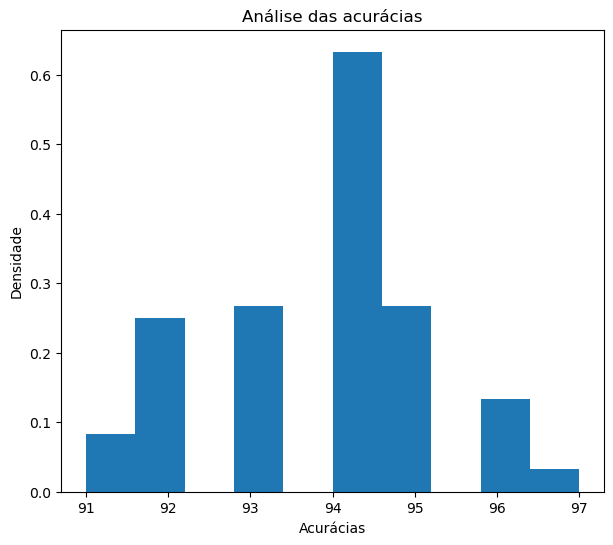

In [75]:
# Criando um histograma para visualizar melhor a distribuição das acurácias
# Definindo a figura
plt.figure(figsize=(7, 6))

# Plotando o gráfico
plt.subplot(111)
plt.hist(acuracia_100, density=True)
plt.xlabel("Acurácias")
plt.ylabel("Densidade")
plt.title("Análise das acurácias")

# Mostrando o gráfico
plt.show()

#### Conclusão:
    Em suma, pode-se notar que o classificador, no geral obtve uma acurácia alta, com média de 92,38%, porém sua mediana foi de 92,5%, sendo assim a maioria dos resultados esteve acima da média (assim como se observa no histograma), algo muito interessante para a empresa visto que apesar da simplicidade do classificador, ele entregou resultados melhores do que o esperado, dessa maneira, com mais investimento no projeto, será possível incrementar novos mecanismos de limpeza de mensagens, assim como de aumentar a base de dados.

    Em relação aos valores que se encontram abaixo do primeiro qualtil (de 88% a 91,5%), uma justificativa para possuirem uma precisão menor em relação ao resto deve-se ao fato de que os dados de treinamento foram sorteados 100 diferentes vezes, e em algumas delas a proporção de comentários relevantes e irrelevantes deve ter sido muito ampla, possuindo muios comentários de só um target, o que induz um maior erro no classificador, pois haverá muitas palavras a mais em uma classe do que na outra, dessa forma a probabilidade de uma palavra pertercenr a classe com um maior numero de dados é maior do que pertercer a outra.

    Da mesma maneira que os resultados pertencentes ao terceiro quartil (93,5% a 96,5%) possuem uma coletânea de treinamento muito bem sepearada, sendo a quantidade de cometários relevantes e irrelevantes aproximadamente a mesma, permitindo que o classificador avalie com mais propriedade um comentário, evitando classificações incorretas.

    Portanto, construir um classificador baseado em somente uma única divisão da base de dados em treinamento e em teste pode ser um pouco arriscado, pois há chances dele possuir uma acurácia muito alta, assim como uma muito baixa. Porém, levando em consideração nossos dados, o desvio padrão dos dados de todas acurácias é consideravelmente baixo, de somento 1,4%, o que pode levar a acreditar que os riscos de dividir os dados em treino e teste uma única vez pode não ser muito grande.

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas categorias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por categoria (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**